<a href="https://colab.research.google.com/github/MichalSuchocki/Military-Aircraft-Classification/blob/main/Mil_aircraft_classification_mobilenetv2_50%25_acc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Libraries

import torch
!pip install pytorch_lightning
import pytorch_lightning as pl
!pip install torchmetrics
import torchmetrics
import torchvision

from torchvision.models import mobilenet_v2
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.2/721.2 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 43.2 MB/s eta 0:00:00


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

train_path = '/content/drive/My Drive/Aux/train'
test_path = '/content/drive/My Drive/Aux/test'
valid_path = '/content/drive/My Drive/Aux/val'

Mounted at /content/drive/


In [4]:
# LightingModel

class LightningModel(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model

        self.save_hyperparameters(ignore=['model'])

        self.train_acc = torchmetrics.Accuracy(num_classes=46,
                                               task='multiclass')
        self.valid_acc = torchmetrics.Accuracy(num_classes=46,
                                               task='multiclass')
        self.test_acc = torchmetrics.Accuracy(num_classes=46,
                                              task='multiclass')

    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)
        loss = torch.nn.functional.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)

        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("train_loss", loss)

        self.model.eval()
        with torch.no_grad():
            _, true_labels, predicted_labels = self._shared_step(batch)
        self.train_acc.update(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, on_epoch=True, on_step=False)
        self.model.train()
        return loss

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("valid_loss", loss)
        self.valid_acc(predicted_labels, true_labels)
        self.log("valid_acc", self.valid_acc,
                 on_epoch=True, on_step=False, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc, on_epoch=True, on_step=False)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

In [5]:
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 0.01
NUM_WORKERS = 4

transformer = transforms.Compose([
    transforms.Resize((230, 230)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_dataset = ImageFolder(train_path, transform=transformer)
test_dataset = ImageFolder(test_path, transform=transformer)
valid_dataset = ImageFolder(valid_path, transform=transformer)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          drop_last=True,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         num_workers=NUM_WORKERS,
                         drop_last=False,
                         shuffle=False)


class DataModule(pl.LightningDataModule):
    def __init__(self, data_path='./'):
        super().__init__()
        self.data_path = data_path


    def train_dataloader(self):
        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=BATCH_SIZE,
                                  drop_last=True,
                                  shuffle=True,
                                  num_workers=NUM_WORKERS)
        return train_loader

    def val_dataloader(self):
        valid_loader = DataLoader(dataset=valid_dataset,
                                  batch_size=BATCH_SIZE,
                                  drop_last=False,
                                  shuffle=False,
                                  num_workers=NUM_WORKERS)
        return valid_loader

    def test_dataloader(self):
        test_loader = DataLoader(dataset=test_dataset,
                                 batch_size=BATCH_SIZE,
                                 drop_last=False,
                                 shuffle=False,
                                 num_workers=NUM_WORKERS)
        return test_loader


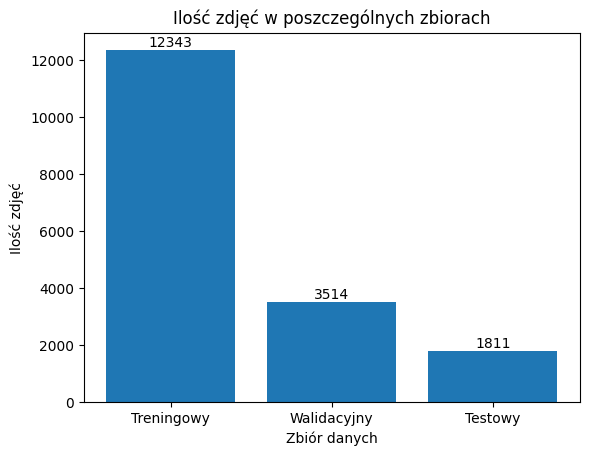

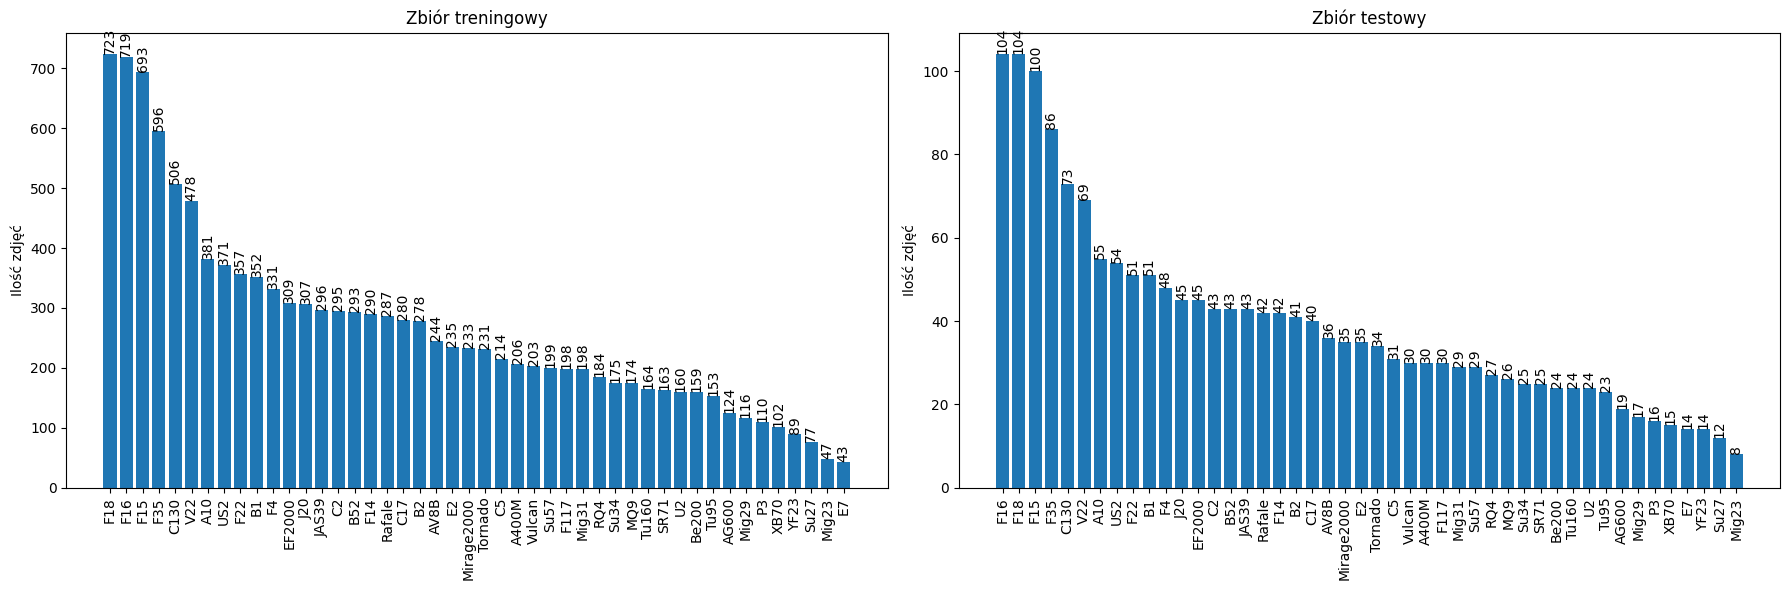

In [6]:
# Plots

import os
import matplotlib.pyplot as plt
import glob

train_count = len(glob.glob(train_path+'/**/*.jpg'))
valid_count = len(glob.glob(valid_path+'/**/*.jpg'))
test_count = len(glob.glob(test_path+'/**/*.jpg'))

def count_files(folder):
    return len([name for name in os.listdir(folder) if os.path.isfile(os.path.join(folder, name))])

train_data = []
val_data = []
test_data = []

for folder in os.listdir(train_path):
    folder_path = os.path.join(train_path, folder)
    if os.path.isdir(folder_path):
        num_files = count_files(folder_path)
        train_data.append((folder, num_files))

for folder in os.listdir(valid_path):
    folder_path = os.path.join(valid_path, folder)
    if os.path.isdir(folder_path):
        num_files = count_files(folder_path)
        val_data.append((folder, num_files))

for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    if os.path.isdir(folder_path):
        num_files = count_files(folder_path)
        test_data.append((folder, num_files))

labels = ['Treningowy', 'Walidacyjny', 'Testowy']
data = [sum([count for _, count in train_data]),
        sum([count for _, count in val_data]),
        sum([count for _, count in test_data])]

plt.bar(labels, data)

for i, count in enumerate(data):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.xlabel('Zbiór danych')
plt.ylabel('Ilość zdjęć')
plt.title('Ilość zdjęć w poszczególnych zbiorach')
plt.show()

train_data.sort(key=lambda x: x[1], reverse=True)
test_data.sort(key=lambda x: x[1], reverse=True)

plt.figure(figsize=(18, 6))

train_labels = [folder for folder, _ in train_data]
train_counts = [count for _, count in train_data]

plt.subplot(1, 2, 1)
plt.bar(train_labels, train_counts)
plt.ylabel('Ilość zdjęć')
plt.title('Zbiór treningowy')
plt.xticks(rotation=90)

for i, count in enumerate(train_counts):
    plt.text(i, count, str(count), ha='center', va='bottom',  rotation=90)

test_labels = [folder for folder, _ in test_data]
test_counts = [count for _, count in test_data]

plt.subplot(1, 2, 2)
plt.bar(test_labels, test_counts)
plt.ylabel('Ilość zdjęć')
plt.title('Zbiór testowy')
plt.xticks(rotation=90)

for i, count in enumerate(test_counts):
    plt.text(i, count, str(count), ha='center', va='bottom',  rotation=90)

plt.tight_layout()
plt.show()

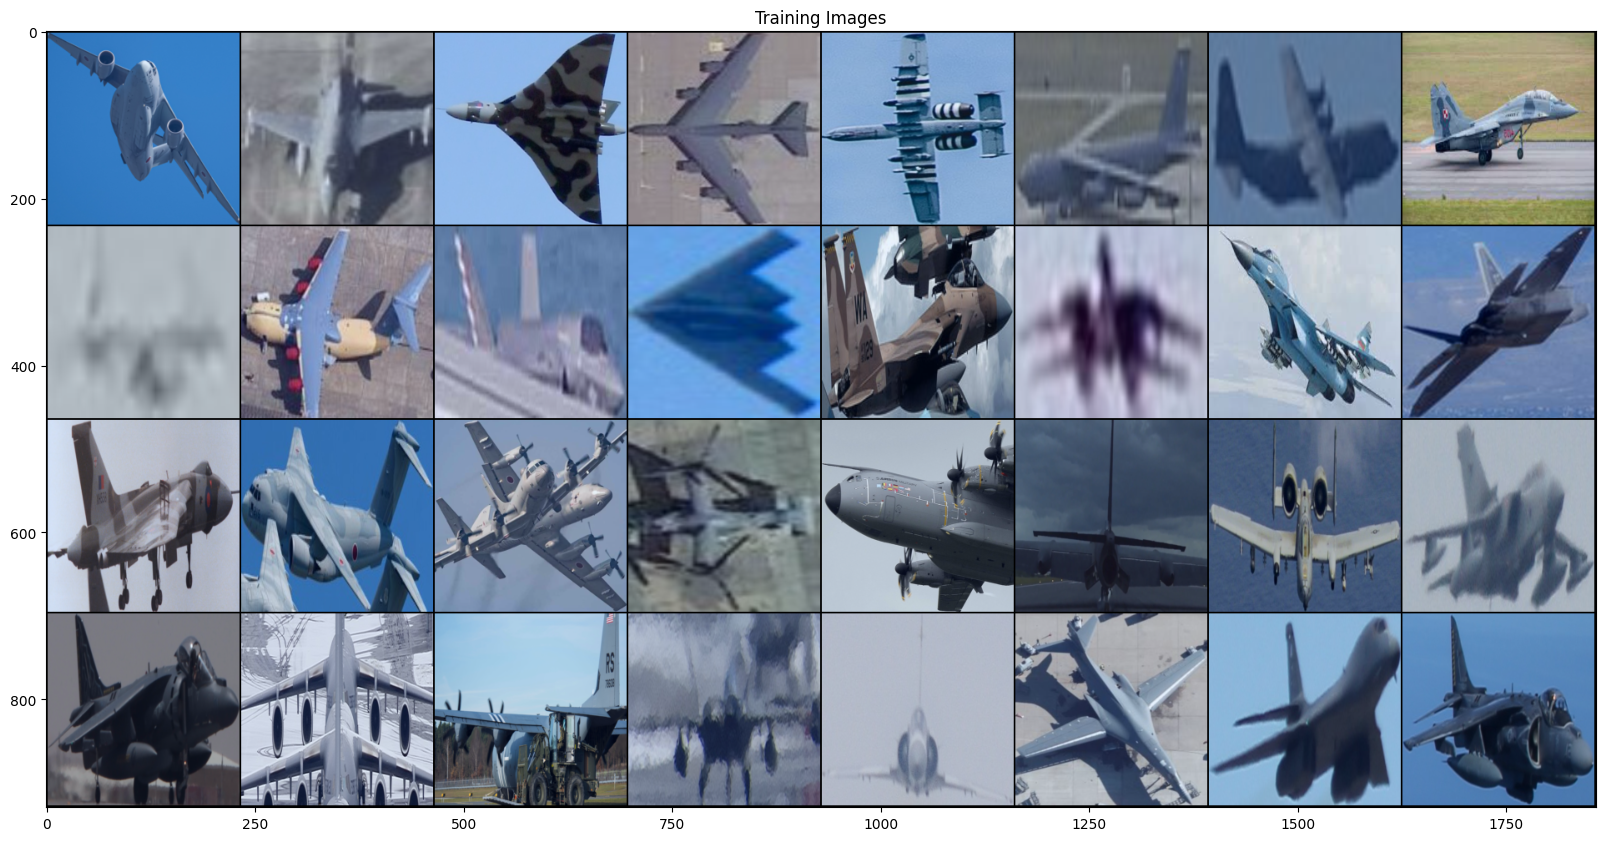

In [7]:
# Sample training images

import numpy as np

for images, labels in train_loader:
    break

plt.figure(figsize=(20, 20))
plt.axis("on")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:64],
    padding=2,
    normalize=True),
    (1, 2, 0)))
plt.show()

In [8]:
pytorch_model = torch.hub.load(
    'pytorch/vision:v0.11.0',
    'mobilenet_v2',
    pretrained=False)

torch.manual_seed(1)
data_module = DataModule(data_path='./data')


lightning_model = LightningModel(
    pytorch_model, learning_rate = 0.01)

callbacks = [ModelCheckpoint(
    save_top_k=1, mode='max', monitor="valid_acc")]  # save top 1 model
logger = CSVLogger(save_dir="logs/", name="my-model")

import time


trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    callbacks=callbacks,
    accelerator="auto",  # Uses GPUs or TPUs if available
    devices="auto",  # Uses all available GPUs/TPUs if applicable
    logger=logger,
    log_every_n_steps=100)

start_time = time.time()
trainer.fit(model=lightning_model, datamodule=data_module)

runtime = (time.time() - start_time)/60
print(f"Training took {runtime:.2f} min. in total.")

Downloading: "https://github.com/pytorch/vision/zipball/v0.11.0" to /root/.cache/torch/hub/v0.11.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VI

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Training took 136.35 min. in total.


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/my-model/version_0/checkpoints/epoch=48-step=18865.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at logs/my-model/version_0/checkpoints/epoch=48-step=18865.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.506902277469635     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.506902277469635}]

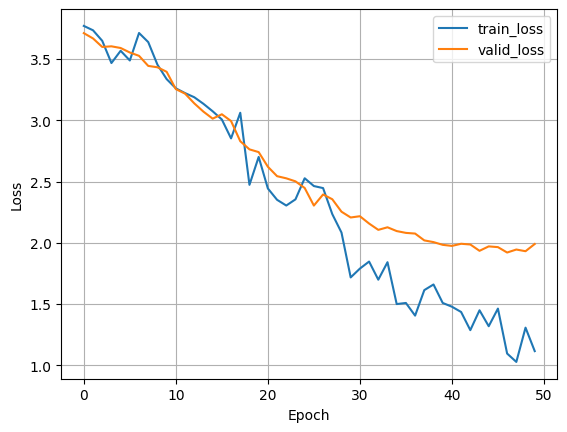

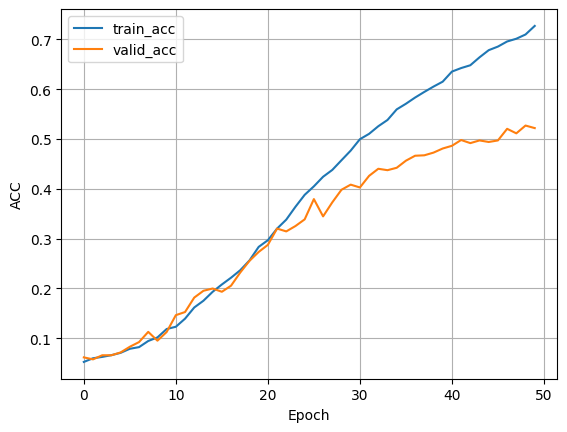

In [9]:
import pandas as pd


metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "valid_loss"]].plot(
    grid=True, legend=True, xlabel='Epoch', ylabel='Loss')
df_metrics[["train_acc", "valid_acc"]].plot(
    grid=True, legend=True, xlabel='Epoch', ylabel='ACC')

trainer.test(model=lightning_model, datamodule=data_module, ckpt_path='best')

In [11]:
path = trainer.checkpoint_callback.best_model_path
print(path)

lighting_model = LightningModel.load_from_checkpoint(
    path, model=pytorch_model)
lighting_model.eval();

logs/my-model/version_0/checkpoints/epoch=48-step=18865.ckpt


In [31]:
test_dataloader = data_module.test_dataloader()

all_true_labels = []
all_predicted_labels = []

for batch in test_dataloader:
    features, labels = batch

    features = features.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        logits = lightning_model(features)

    predicted_labels = torch.argmax(logits, dim=1)
    all_predicted_labels.append(predicted_labels)
    all_true_labels.append(labels)

all_predicted_labels = torch.cat(all_predicted_labels)
all_true_labels = torch.cat(all_true_labels)
all_predicted_labels[:5]

test_acc = torch.mean((all_predicted_labels == all_true_labels).float())
print(f'Test accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)')

Test accuracy: 0.4975 (49.75%)


In [48]:
class_dict = {
    0: 'A10',
    1: 'A400M',
    2: 'AG600',
    3: 'AV8B',
    4: 'B1',
    5: 'B2',
    6: 'B52',
    7: 'Be200',
    8: 'C130',
    9: 'C17',
    10: 'C2',
    11: 'C5',
    12: 'E2',
    13: 'E7',
    14: 'EF2000',
    15: 'F117',
    16: 'F14',
    17: 'F15',
    18: 'F16',
    19: 'F18',
    20: 'F22',
    21: 'F35',
    22: 'F4',
    23: 'J20',
    24: 'JAS39',
    25: 'MQ9',
    26: 'Mig23',
    27: 'Mig29',
    28: 'Mig31',
    29: 'Mirage2000',
    30: 'P3',
    31: 'RQ4',
    32: 'Rafale',
    33: 'SR71',
    34: 'Su27',
    35: 'Su34',
    36: 'Su57',
    37: 'Tornado',
    38: 'Tu160',
    39: 'Tu95',
    40: 'U2',
    41: 'US2',
    42: 'V22',
    43: 'Vulcan',
    44: 'XB70',
    45: 'YF23'
}


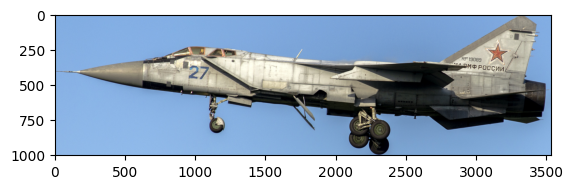

28
Predicted label: Mig31
Class probability: 99.85%


In [57]:
from PIL import Image

image = Image.open('/content/drive/My Drive/Aux/val/Mig31/d3f780d0ec6d4705dce8f12cf1e809a7_0.jpg')
plt.imshow(image, cmap='Greys')
plt.show()

transform = transformer
image_chw = transform(image)
image_nchw = image_chw.unsqueeze(0)

image_nchw = image_nchw.to(device)

with torch.no_grad():
    logits = lightning_model(image_nchw)
    probas = torch.softmax(logits, axis=1)
    predicted_label = torch.argmax(probas).item()
    print(predicted_label)

print(f'Predicted label: {class_dict[predicted_label]}')
print(f'Class probability: {probas[0][predicted_label]*100:.2f}%')
